In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import seaborn as sns
import cupy as cp
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
# Load the dataset
path = 'C:/Users/trngd/InternalDoc/code_projects/python-logistic-regression/dataset/'
data = pd.read_csv(path + 'loan_data.csv')
data.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [4]:
scaler = StandardScaler()

features = data[['person_age', 
                'person_income', 
                'person_emp_exp',  
                'loan_amnt', 
                'loan_int_rate',
                'loan_percent_income',
                'cb_person_cred_hist_length',
                'credit_score',
               ]]

labels = data['loan_status']

#Split data into 80% for training and 20% for testing
x_train_raw, x_test_raw, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=43, stratify=labels
)

scaler.fit(x_train_raw)
x_train_scaled = scaler.transform(x_train_raw)
x_test_scaled = scaler.transform(x_test_raw)

print(f"Training set shape: {x_train_scaled.shape}")
print(f"Testing set shape: {x_test_scaled.shape}")

Training set shape: (36000, 8)
Testing set shape: (9000, 8)


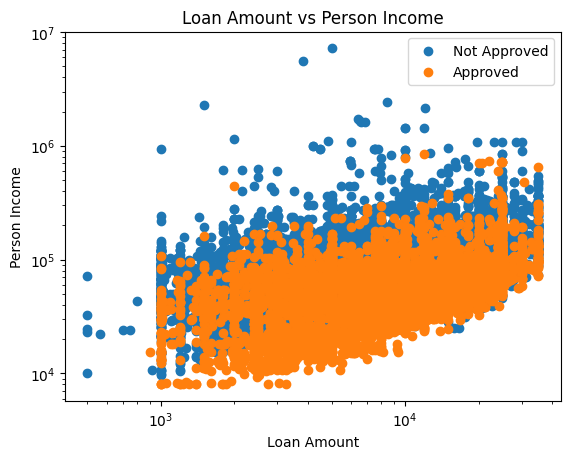

In [9]:
plt.scatter(x_train_raw[y_train == 0]['loan_amnt'], x_train_raw[y_train == 0]['person_income'], 
            color = 'tab:blue', label = 'Not Approved')
plt.scatter(x_train_raw[y_train == 1]['loan_amnt'], x_train_raw[y_train == 1]['person_income'], 
            color = 'tab:orange', label = 'Approved')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Loan Amount')
plt.ylabel('Person Income')
plt.title('Loan Amount vs Person Income')
plt.legend()
plt.show()

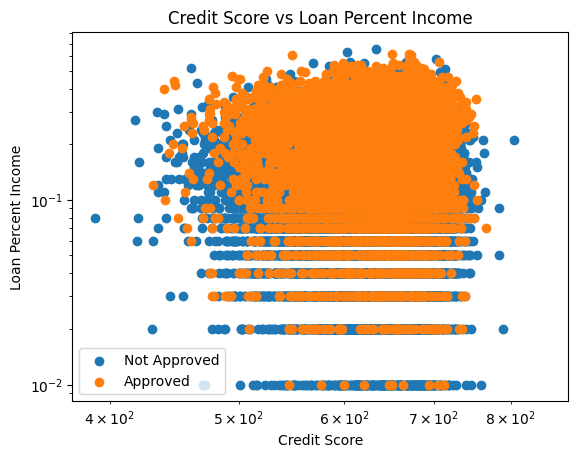

In [ ]:
plt.scatter(x_train_raw[y_train == 0]['credit_score'], x_train_raw[y_train == 0]['loan_percent_income'],
            color = 'tab:blue', label = 'Not Approved')
plt.scatter(x_train_raw[y_train == 1]['credit_score'], x_train_raw[y_train == 1]['loan_percent_income'],
            color = 'tab:orange', label = 'Approved')

plt.xlabel('Credit Score')
plt.ylabel('Loan Percent Income')
plt.title('Credit Score vs Loan Percent Income')
plt.legend()
plt.show()

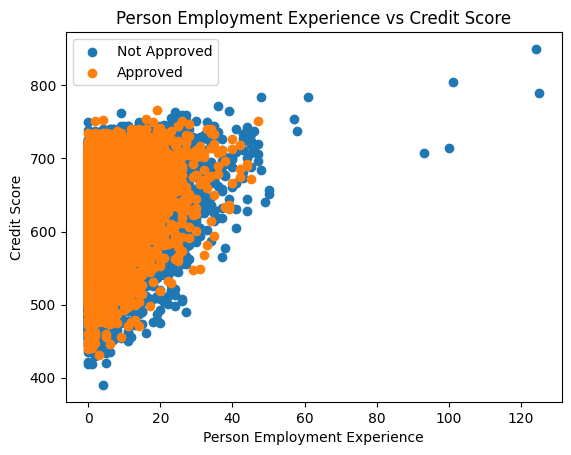

In [12]:
plt.scatter(x_train_raw[y_train == 0]['person_emp_exp'], x_train_raw[y_train == 0]['credit_score'],
            color = 'tab:blue', label = 'Not Approved')
plt.scatter(x_train_raw[y_train == 1]['person_emp_exp'], x_train_raw[y_train == 1]['credit_score'],
            color = 'tab:orange', label = 'Approved')
plt.xlabel('Person Employment Experience')
plt.ylabel('Credit Score')
plt.title('Person Employment Experience vs Credit Score')
plt.legend()
plt.show()

In [13]:
def sigmoid(z):
    # This is already vectorized, no change needed
    return 1 / (1 + np.exp(-z))

def cost_function(x, y, w, b):
    m = x.shape[0]
    z = x @ w + b  # Vectorized prediction for all samples
    y_hat = sigmoid(z)
    # Vectorized cost calculation
    cost = -(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
    return np.mean(cost)

def gradient_function(x, y, w, b):
    m = x.shape[0]
    z = x @ w + b  # Vectorized prediction
    y_hat = sigmoid(z)
    error = y_hat - y
    
    # Vectorized gradient calculation
    grad_w = (x.T @ error) / m
    grad_b = np.mean(error)
    
    return grad_w, grad_b

def gradient_descent(x, y, alpha, iterations):
    # No need for global n, get it from the data shape
    n = x.shape[1]
    w = np.zeros(n)
    b = np.array(0.0) # Use a cupy scalar

    for i in range(iterations):
        grad_w, grad_b = gradient_function(x, y, w, b)
        w = w - alpha * grad_w
        b = b - alpha * grad_b

        if i % 1000 == 0:
            cost = cost_function(x, y, w, b)
            # Use .item() to print a value from the GPU
            print(f"Iteration {i}, Cost: {cost.item():.4f}")

    return w, b

def predict(x, w, b):
    # Vectorized prediction
    z = x @ w + b
    y_hat = sigmoid(z)
    return (y_hat >= 0.5).astype(int)

In [14]:
learning_rate = 0.01
iterations = 10000

x_train_cupy = np.asarray(x_train_scaled)
y_train_cupy = np.asarray(y_train.to_numpy())

w, b = gradient_descent(x_train_cupy, y_train_cupy, learning_rate, iterations)

Iteration 0, Cost: 0.6919
Iteration 1000, Cost: 0.4182
Iteration 2000, Cost: 0.3985
Iteration 3000, Cost: 0.3936
Iteration 4000, Cost: 0.3919
Iteration 5000, Cost: 0.3912
Iteration 6000, Cost: 0.3908
Iteration 7000, Cost: 0.3906
Iteration 8000, Cost: 0.3904
Iteration 9000, Cost: 0.3903


In [1]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

test_predictions = predict(cp.asarray(x_test_scaled), cp.asarray(w), cp.array(b))
test_predictions = cp.asnumpy(test_predictions)

print("Test Set Classification Report:  \n")
print(confusion_matrix(y_test, test_predictions))

print("\n")
print(classification_report(y_test, test_predictions))




NameError: name 'predict' is not defined